In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get current working directory
cwd = os.getcwd()

# Load the dataset
df = pd.read_csv(cwd + "/filtered_customer_booking.csv", index_col=0)
df = df.reset_index(drop=True)

# Display the dataset
print("Dataset Overview:")
print(df)

Dataset Overview:
       num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49977               2      Internet  RoundTrip             27               6   
49978               1      Internet  RoundTrip            111               6   
49979               1      Internet  RoundTrip             24               6   
49980               1      Internet  RoundTrip             15               6   
49981               1      Internet  RoundTrip             19               6   

       fl

In [3]:
# Create a final dataframe to store processed data
df_final = df

# Import necessary libraries
from sklearn.preprocessing import OneHotEncoder

# Create an instance of one hot encoder with 'ignore' handle_unknown
encoder = OneHotEncoder(handle_unknown='ignore')

In [4]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49978,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49979,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49980,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [5]:
# One hot encode 'sales_channel'
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)


In [6]:
# One hot encode 'trip_type'
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip', 2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [7]:
# Drop categorical columns
df_final.drop(['sales_channel', 'trip_type', 'booking_origin', 'route'], axis=1, inplace=True)

In [8]:
# Store the label for supervised learning
label = df['booking_complete']
df_final = df_final.drop('booking_complete', axis=1)

In [9]:
# Normalize the values using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_final)
scaled_df = pd.DataFrame(scaled_df, columns=df_final.columns)
scaled_df['label'] = label

In [10]:
# Display normalized dataset
print("\nNormalized Dataset:")
print(scaled_df)


Normalized Dataset:
       num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0            0.400769       1.971093       -0.119401    -0.381588    1.096876   
1           -0.579424       0.302987       -0.089895    -1.120618    1.096876   
2            0.400769       1.759799       -0.030885     1.465988   -0.408618   
3           -0.579424       0.125056        0.234662    -0.935861    1.096876   
4            0.400769      -0.186323       -0.030885     1.096473   -0.408618   
...               ...            ...             ...          ...         ...   
49977        0.400769      -0.642272       -0.502969    -0.012073    1.096876   
49978       -0.579424       0.291867       -0.502969    -0.935861    1.598707   
49979       -0.579424      -0.675634       -0.502969     2.389776    1.096876   
49980       -0.579424      -0.775721       -0.502969     0.357443   -1.412280   
49981       -0.579424      -0.731238       -0.502969     0.172685    0.093214   

      

<Axes: >

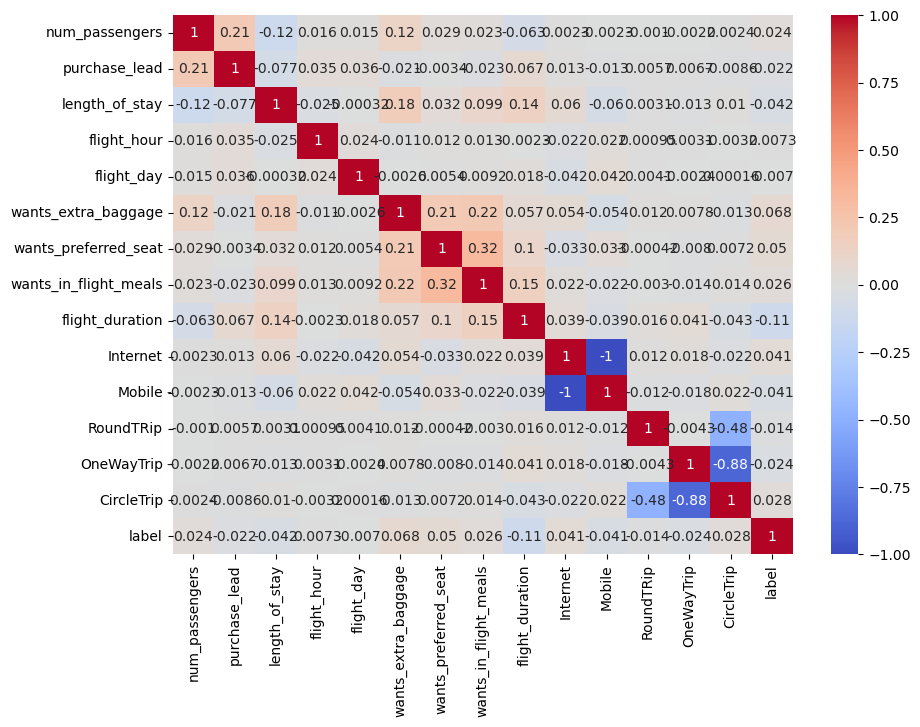

In [11]:
# Calculate correlation matrix and plot heatmap
corr = scaled_df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [12]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X = scaled_df.iloc[:, :-1]
y = scaled_df['label']
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

In [13]:
# Import necessary libraries for modeling and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from yellowbrick.classifier import ConfusionMatrix

In [14]:
# Define functions for modeling and evaluation
def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

In [15]:
# Create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth=50, min_samples_split=5, random_state=0)

In [16]:
# Check training accuracy
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

In [17]:
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"F1-Score: {f1_train:.2f}")


Training Metrics:
Accuracy: 0.93
Precision: 1.00
F1-Score: 0.72


<Axes: >

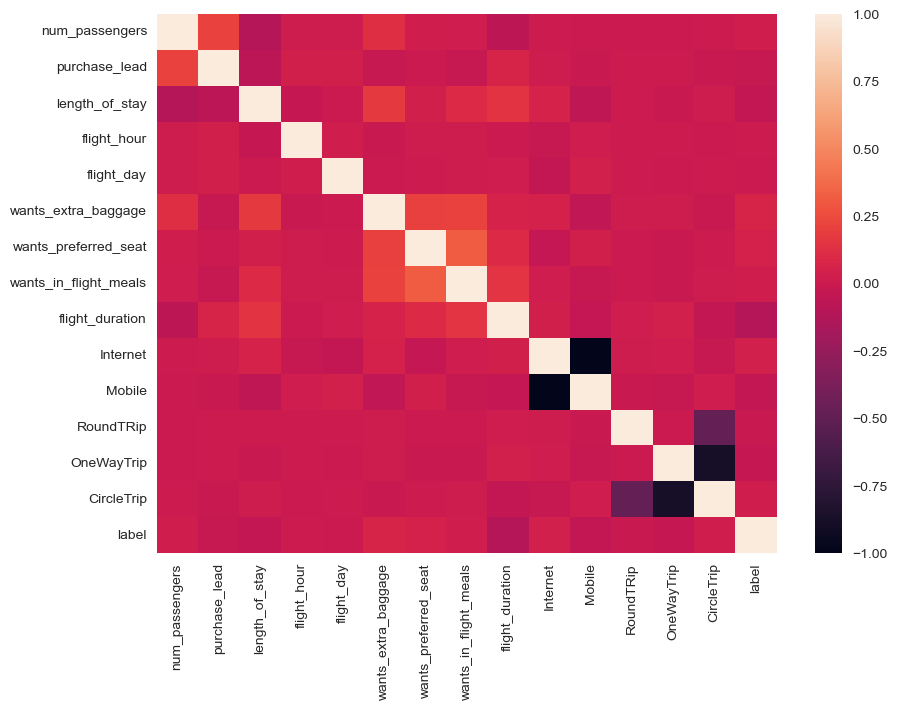

In [18]:
corr = scaled_df.corr()

plt.figure(figsize=(10,7))

#plot the heatmap
sns.heatmap(corr)

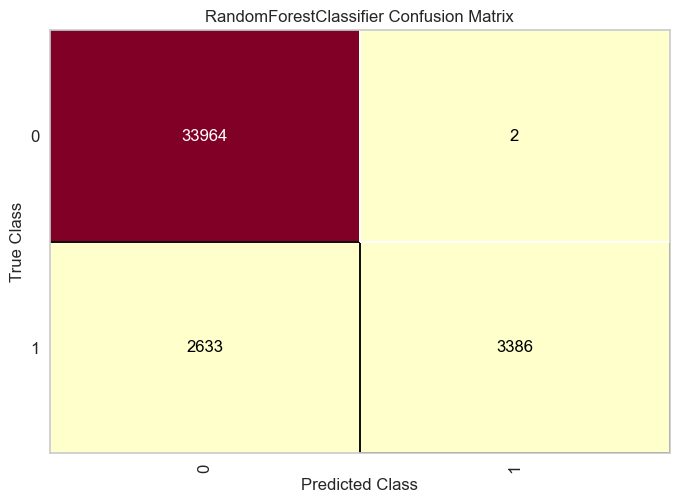

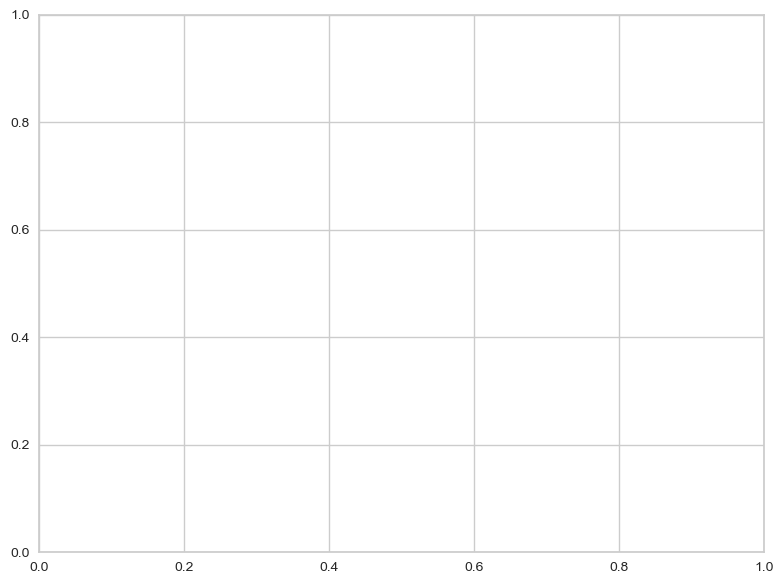

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [19]:
# Plot Confusion Matrix for training data
cm_train = ConfusionMatrix(clf_rf, classes=[0, 1])
cm_train.fit(X_train, y_train)
cm_train.score(X_train, y_train)
plt.figure(figsize=(8, 6))
cm_train.poof(ax=plt.gca())

In [20]:
# Check testing accuracy
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

In [21]:

print("\nTesting Metrics:")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"F1-Score: {f1_test:.2f}")


Testing Metrics:
Accuracy: 0.86
Precision: 0.56
F1-Score: 0.07


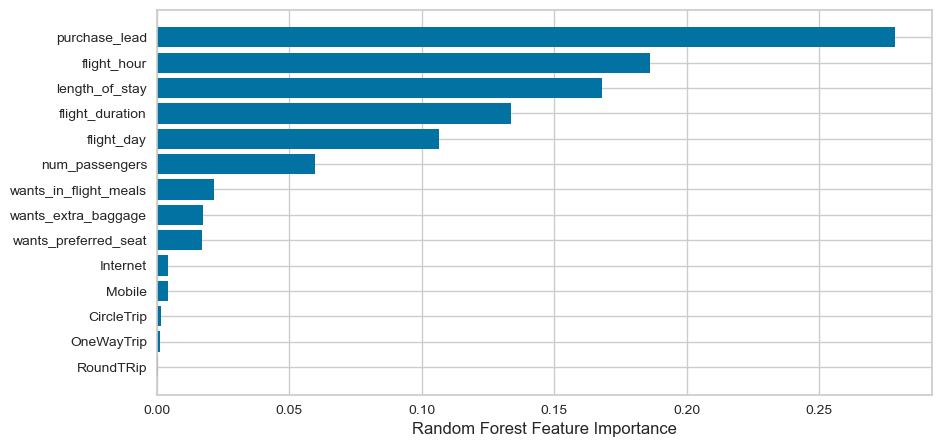

In [22]:
# Plot Feature Importance
plt.figure(figsize=(10, 5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [23]:
# Balance the dataset by oversampling the minority class
scaled_df.label.value_counts()

0    42506
1     7476
Name: label, dtype: int64

In [24]:
# Create a dataframe with all label 0 samples
scaled_df_0 = scaled_df[scaled_df.label == 0].sample(n=8000)

In [25]:
# Concatenate the dataframes to balance the dataset
scaled_df_new = pd.concat([scaled_df[scaled_df.label == 1], scaled_df_0], ignore_index=True)
scaled_df_new = scaled_df_new.sample(frac=1).reset_index(drop=True)

0.9341002876078529

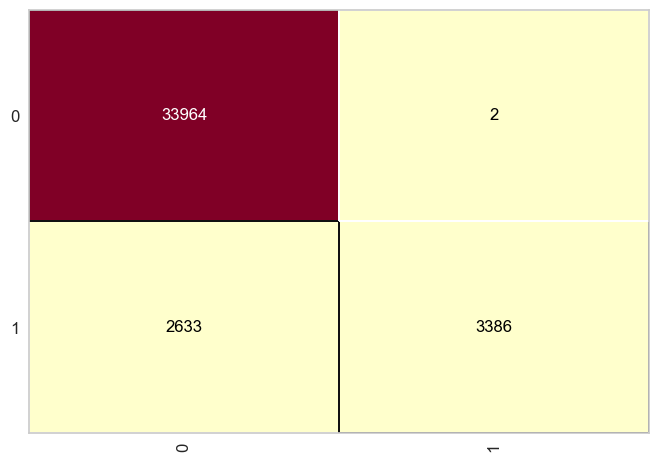

In [26]:
cm = ConfusionMatrix(clf_rf, classes=[0,1])
cm.fit(X_train, y_train)

cm.score(X_train, y_train)

In [29]:
# Split the balanced dataset
X = scaled_df_new.iloc[:, :-1]
y = scaled_df_new['label']
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42)

# Create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=5, random_state=0)
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

# Calculate metrics for balanced dataset
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
specificity_test = recall_score(y_test, y_pred_test, pos_label=0)

print("\nMetrics for Balanced Testing Data:")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"Specificity: {specificity_test:.2f}")
print(f"F1-Score: {f1_test:.2f}")


Metrics for Balanced Testing Data:
Accuracy: 0.61
Precision: 0.60
Recall: 0.59
Specificity: 0.64
F1-Score: 0.60


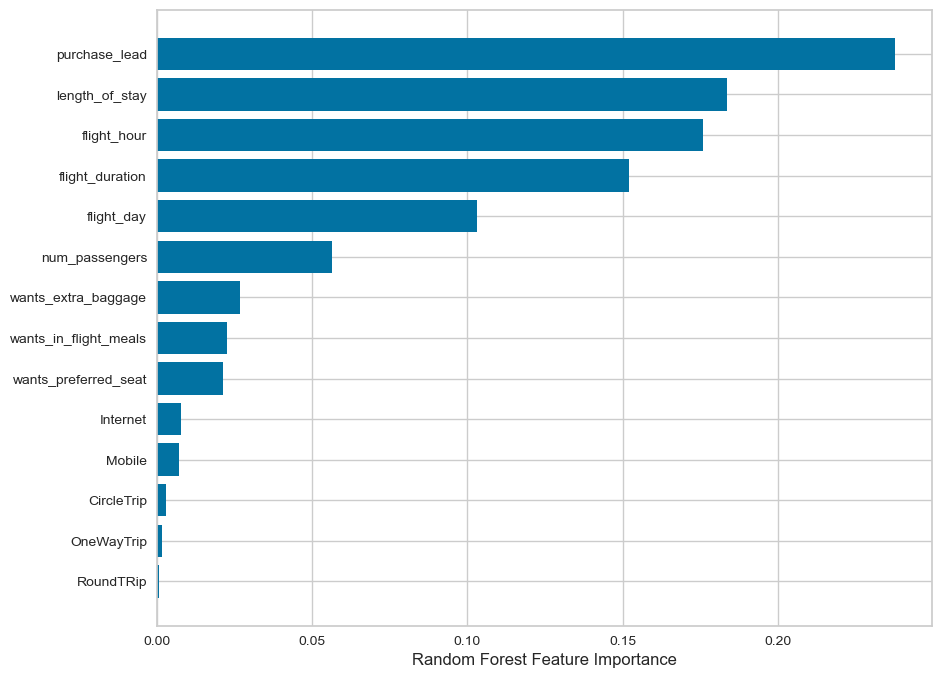

In [30]:
# Plot Feature Importance for balanced dataset
plt.figure(figsize=(10, 8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()